In [3]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline

# Based on the paper by A. Harzallah, Monthly Weather Review, 1995
https://doi.org/10.1175/1520-0493(1995)123%3C2251:TIODSU%3E2.0.CO;2
As referenced by: whuber https://stats.stackexchange.com/users/919/whuber
on stackexchange: https://stats.stackexchange.com/questions/59418/interpolation-of-influenza-data-that-conserves-weekly-mean investigation notebook: https://github.com/SalishSeaCast/analysis-susan/blob/master/notebooks/Rivers/TryDailyfromMonthlyAverages.ipynb 

In [4]:
monthlymeans = xr.open_dataset('~/MEOPAR/rivers-climatology/watershed_climatologies/Salish_allrivers_monthly.nc')

In [12]:
# Get an array "months" that has the middle of the month for three years
months = pd.date_range(start='2018/01', end='2021/01', freq='SM') # gets start and 15th
months = np.array(months[0::2])   # drops start
# Correct February
months[1] = datetime.datetime(2018, 2, 14)
months[13] = datetime.datetime(2019, 2, 14)
months[25] = datetime.datetime(2020, 2, 14)

In [23]:
# Basic function to do one linear fit iteration and find the difference from the means
def one_iteration(months, So):
    sdaily = So.resample('1D').interpolate(method='cubic', order=3)
    monthlymeans = sdaily.resample('1M').mean()
    S1 = pd.DataFrame(monthlymeans.values, months, columns=['WSflux']) - So
    return sdaily, S1 

In [80]:
# Iteration Code
def iterations(data, months, noiters):
    So = pd.DataFrame(data, months, columns=['WSflux'])
    sdaily_sum, Siter = one_iteration(months, So) 
    for iteration in range(2, noiters+1):
        sdaily_iter, Snext = one_iteration(months, Siter)
        sdaily_sum = sdaily_sum + sdaily_iter
        Siter = Snext
    print('Fractional Error = ', Siter.WSflux[12:-12].abs().max() / So.WSflux.min())
    return sdaily_sum

In [82]:
daily_series = {}
for key in monthlymeans.variables.keys():
    if key != 'time_counter':
        print(key)
        data = np.array(monthlymeans[key])
        threeyears = np.concatenate((data, data, data))
        daily_series[key] = iterations(threeyears, months, 5)

fraser
Fractional Error =  0.00025044827309553464
skagit
Fractional Error =  0.0006416597273574798
evi_n
Fractional Error =  0.0018013742802677813
howe
Fractional Error =  0.00018009807451633257
bute
Fractional Error =  0.0003912714507424604
puget
Fractional Error =  0.00015144652281032694
jdf
Fractional Error =  0.002566249224782746
evi_s
Fractional Error =  0.0006928774242516952
jervis
Fractional Error =  0.0005895815378365796
toba
Fractional Error =  0.0009146534346931525


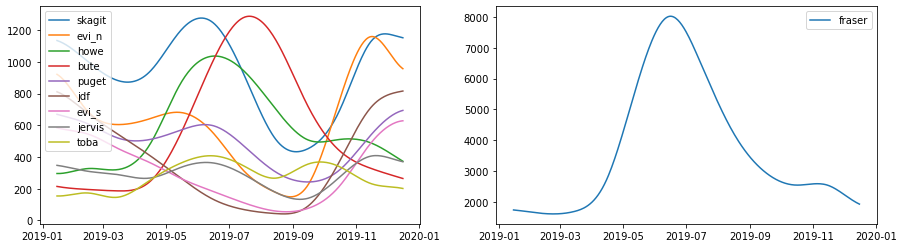

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
for key in daily_series:
    if key != 'fraser':
        ax = axs[0]
    else:
        ax = axs[1]
    ax.plot(daily_series[key][365:-365], label=key)
for ax in axs:
    ax.legend()

### Put it in an xrray and into a netcdf file

In [86]:
daily_dataset = xr.Dataset(
    {
        "fraser": (("date"), daily_series['fraser'][351:-350].values[:, 0]),
    },
        {"date" : daily_series['fraser'][351:-350].index},
        attrs = {"Description" : 
                 "Daily climatology of watershed flows, interpolated from Morrison's monthly climatology"}
    )
for key in daily_series:
    if key != 'fraser':
        daily_dataset[key] = xr.DataArray(daily_series[key][351:-350].values[:, 0], dims=["date"])

In [88]:
daily_dataset.to_netcdf("Salish_allrivers_daily.nc")